### **Forecasting EL Nino/Southern Oscillation**
**Reference:** Climate Change AI Summer School 2023<br>
**Code modified by:** Gary Sampson

In [2]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.4 MB/s eta 0:00:00


In [3]:
%matplotlib inline
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import sklearn.ensemble
import scipy.stats
import xgboost
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.stats import pearsonr
from scipy.stats import reciprocal, uniform
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve
import tensorflow as tf
import keras_tuner as kt
from functools import partial

tf.random.set_seed(42)

In [4]:
#Download Nino3.4 index (this index measures the state of ENSO by encoding the average
#temperature anomaly in the equatorial Pacific)
!gdown --id 1aGvitA8rYrHRDxNd2XD4AAFsahCQsv0t

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1aGvitA8rYrHRDxNd2XD4AAFsahCQsv0t
To: /content/nino34.long.anom.data.txt
100% 15.4k/15.4k [00:00<00:00, 49.7MB/s]


In [5]:
#Download sst observations from 1880 to 2018
!gdown 1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc

Downloading...
From: https://drive.google.com/uc?id=1-xefk3imP4Q-8GevIV2YIo82iP5rTdSc
To: /content/sst.mon.mean.trefadj.anom.1880to2018.nc
100% 432M/432M [00:03<00:00, 122MB/s]


In [6]:
#Data wrangling

def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_basic_predictors_predictands(start_date, end_date, lead_time,
                                    use_pca=False, n_components=32):
  """
  inputs
  ------

      start_date        str : the start date from which to extract sst
      end_date          str : the end date
      lead_time         str : the number of months between each sst
                              value and the target Nino3.4 Index
      use_pca          bool : whether or not to apply principal components
                              analysis to the sst field
      n_components      int : the number of components to use for PCA

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies)
      and the predictands (np array the ENSO index at the specified lead time).

  """
  ds = xr.open_dataset('sst.mon.mean.trefadj.anom.1880to2018.nc')
  sst = ds['sst'].sel(time=slice(start_date, end_date))
  num_time_steps = sst.shape[0]

  #sst is a 3D array: (time_steps, lat, lon)
  #in this tutorial, we will not be using ML models that take
  #advantage of the spatial nature of global temperature
  #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
  #(At each time step, there are lat*lon predictors)
  sst = sst.values.reshape(num_time_steps, -1)
  sst[np.isnan(sst)] = 0

  #Use Principal Components Analysis, also called
  #Empirical Orthogonal Functions, to reduce the
  #dimensionality of the array
  if use_pca:
    #create an option to apply the PCA operation learned
    #on the train set to the test set.  Currently, PCA is performed
    #independently on the train set and test set.
    pca = sklearn.decomposition.PCA(n_components=n_components)
    pca.fit(sst)
    X = pca.transform(sst)
  else:
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  y = load_enso_indices()[slice(start_date_plus_lead,
                                end_date_plus_lead)]


  ds.close()
  return X, y

def plot_nino_time_series(y, predictions, title):
  """
  inputs
  ------
    y           pd.Series : time series of the true Nino index
    predictions np.array  : time series of the predicted Nino index (same
                            length and time as y)
    titile                : the title of the plot

  outputs
  -------
    None.  Displays the plot
  """
  predictions = pd.Series(predictions, index=y.index)
  predictions = predictions.sort_index()
  y = y.sort_index()

  plt.plot(y, label='Ground Truth')
  plt.plot(predictions, '--', label='ML Predictions')
  plt.legend(loc='best')
  plt.title(title)
  plt.ylabel('Nino3.4 Index')
  plt.xlabel('Date')
  plt.show()
  plt.close()

In [30]:
# Get train, val, and test sets
X_train, y_train = assemble_basic_predictors_predictands('1950-01-01','2005-12-31', lead_time=3)
X_test, y_test = assemble_basic_predictors_predictands('2007-01-01','2017-12-31', lead_time=3)
print('X_train, y_train shape:', X_train.shape, y_train.shape)
print('X_test, y_test shape:', X_test.shape, y_test.shape)

X_train, y_train shape: (672, 64800) (672,)
X_test, y_test shape: (132, 64800) (132,)


In [31]:
X_train_df = pd.DataFrame(X_train)
y_train_new_idx = y_train.reset_index()
train_df = pd.concat([X_train_df, y_train_new_idx], axis=1).drop(['index'], axis=1)
train_df.shape

(672, 64801)

In [32]:
#Shuffle the training data then drop the last column to get X_train_shuffle
train_df = train_df.sample(frac=1, axis=0 ,random_state=42)

In [33]:
X_train_shuffled = train_df.iloc[:, :-1]
y_train_shuffled = train_df.iloc[:, -1]
print('X_train_shuffled shape:',X_train_shuffled.shape)
print('y_train_shuffled shape:',y_train_shuffled.shape)

X_train_shuffled shape: (672, 64800)
y_train_shuffled shape: (672,)


In [34]:
#Ridge Regression
regr_3_month_ridge = Ridge(alpha=8000.0, random_state=42)
ridge_rmses = -cross_val_score(regr_3_month_ridge, X_train_shuffled, y_train_shuffled,
                               scoring="neg_root_mean_squared_error", cv=5)
print('mean rms:',ridge_rmses.mean())

mean rms: 0.35242218108776446


In [35]:
#Ridge RandomizedSearchCV
param_grid_ridge = {'alpha': uniform(1.0, 800.0)}
ridge_reg_3_month = Ridge()
rnd_search_ridge = RandomizedSearchCV(ridge_reg_3_month, param_distributions=param_grid_ridge, cv=5,
                                      scoring="neg_root_mean_squared_error", return_train_score=True)
rnd_search_ridge.fit( X_train_shuffled, y_train_shuffled)

RandomizedSearchCV(cv=5, estimator=Ridge(),
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d2fc7cb84c0>},
                   return_train_score=True,
                   scoring='neg_root_mean_squared_error')

In [36]:
rnd_search_ridge.best_params_

{'alpha': 219.42066604198465}

In [37]:
-(rnd_search_ridge.best_score_)

0.3438309422300617

In [38]:
def plot_learning_curves(model, X, y):
    train_sizes, train_scores, valid_scores = learning_curve(model, X, y, train_sizes=np.linspace(0.01, 1.0, 20), cv=5,
        scoring="neg_root_mean_squared_error")
    train_errors = -train_scores.mean(axis=1)
    valid_errors = -valid_scores.mean(axis=1)

    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, train_errors, "r", linewidth=2, label="train")
    plt.plot(train_sizes, valid_errors, "b", linewidth=2, label="valid")
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.legend(loc="upper right")
    plt.axis([0, 575, 0, 1.0])
    plt.show()

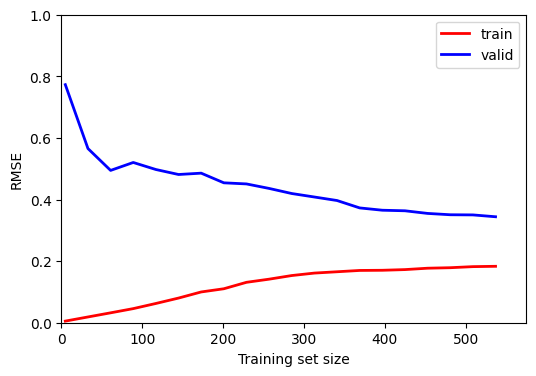

In [39]:
# Plot learning curve for Ridge model
plot_learning_curves(rnd_search_ridge.best_estimator_, X_train_shuffled, y_train_shuffled)

In [40]:
# use pca to reduce dimension of train and test datasets
n_components = 32
pca = sklearn.decomposition.PCA(n_components=n_components)
pca.fit(X_train_shuffled)
X_train_pca = pca.transform(X_train_shuffled)
print('X_train_pca, y_train_shuffled shape:', X_train_pca.shape, y_train_shuffled.shape)

X_train_pca, y_train_shuffled shape: (672, 32) (672,)


In [66]:
#RandonForest GridSearchCV
param_grid_forest = {'n_estimators': [25, 50, 75,100, 125, 150, 175, 200]}
forest_reg_3_month = RandomForestRegressor()
grd_search_forest = GridSearchCV(forest_reg_3_month, param_grid = param_grid_forest, cv=5,
                                      scoring="neg_root_mean_squared_error", return_train_score=True)
grd_search_forest.fit( X_train_pca, y_train_shuffled)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [25, 50, 75, 100, 125, 150, 175, 200]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [67]:
grd_search_forest.best_params_

{'n_estimators': 125}

In [68]:
-(grd_search_forest.best_score_)

0.40428280549034684

In [69]:
#XGBoost Regression GridSearchCV
param_grid_xgboost = {'eta': [0.001, 0.01, 0.1, 0.15, 0.2]}
xgboost_reg_3_month = xgboost.XGBRegressor()
grid_search_xgboost = GridSearchCV(xgboost_reg_3_month, param_grid = param_grid_xgboost, cv=5,
                                   scoring="neg_root_mean_squared_error", return_train_score=True)
grid_search_xgboost.fit( X_train_pca, y_train_shuffled)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'eta': [0.001, 0.01, 0.1, 0.15, 0.2]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [70]:
grid_search_xgboost.best_params_

{'eta': 0.1}

In [71]:
-(grid_search_xgboost.best_score_)

0.36749365757076324

In [72]:
#SVR Regression RandomizedSearchCV

svr_reg = SVR()
param_distrib = {'C': uniform(1, 100),
                'gamma': reciprocal(1e-5, 0.1)}
rnd_search_svr = RandomizedSearchCV(svr_reg, param_distributions= param_distrib, cv=5, scoring="neg_root_mean_squared_error",
                                 return_train_score=True, random_state=42)
rnd_search_svr.fit( X_train_pca, y_train_shuffled)
print(rnd_search_svr.best_estimator_)

SVR(C=44.194501864211574, gamma=0.00014618962793704957)


In [73]:
print(-cross_val_score(rnd_search_svr.best_estimator_, X_train_pca, y_train_shuffled,
                       scoring="neg_root_mean_squared_error", cv=5,).mean())

0.27199324288451737


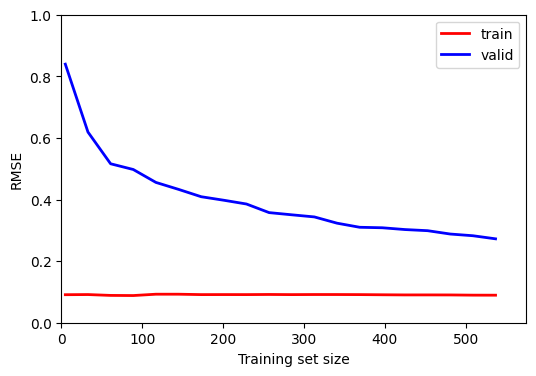

In [74]:
# Plot learning curve for SVM model
plot_learning_curves(rnd_search_svr.best_estimator_, X_train_pca, y_train_shuffled)

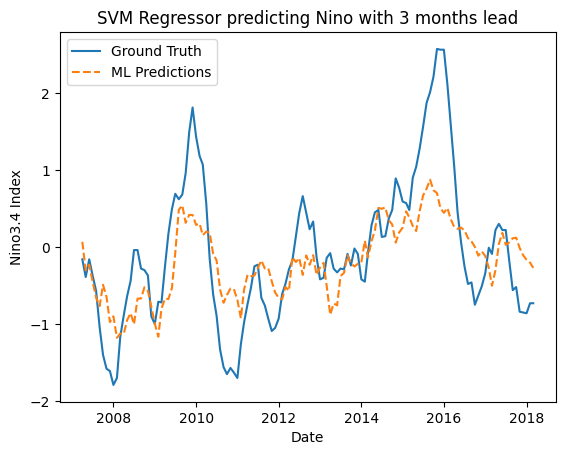

In [75]:
#Plot predictions using the best SVR model
X_test_pca = pca.transform(X_test)
predictions_svr = rnd_search_svr.best_estimator_.predict(X_test_pca)
title = 'SVM Regressor predicting Nino with 3 months lead'
plot_nino_time_series(y_test, predictions_svr, title)

**Deep Neural Networks**

In [76]:
#Split the training data into a train set and a validation set
X_train_pca_df = pd.DataFrame(X_train_pca)
y_train_shuffled_df = pd.Series(y_train_shuffled)
X_train_pca_split = X_train_pca_df.iloc[:540, :]
y_train_split = y_train_shuffled_df.iloc[:540]
X_val_split = X_train_pca_df.iloc[540:, :]
y_val_split = y_train_shuffled_df.iloc[540:]
print('X_train_pca_split, y_train_split shape :',X_train_pca_split.shape, y_train_split.shape)
print('X_val_split, y_val_split shape :',X_val_split.shape,y_val_split.shape)

X_train_pca_split, y_train_split shape : (540, 32) (540,)
X_val_split, y_val_split shape : (132, 32) (132,)


In [77]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# MLP with flatten(latitude*longitude) input training data
base_model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation="relu", input_shape=X_train_pca_split.shape[1:]),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
base_model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
base_model.fit(X_train_pca_split, y_train_split, epochs=30, validation_data=(X_val_split, y_val_split))

Epoch 1/30
17/17 [==============================] - 6s 16ms/step - loss: 2.9682 - root_mean_squared_error: 1.7228 - val_loss: 2.0297 - val_root_mean_squared_error: 1.4247
Epoch 2/30
17/17 [==============================] - 0s 6ms/step - loss: 1.0313 - root_mean_squared_error: 1.0155 - val_loss: 1.0726 - val_root_mean_squared_error: 1.0357
Epoch 3/30
17/17 [==============================] - 0s 5ms/step - loss: 0.4121 - root_mean_squared_error: 0.6419 - val_loss: 0.6363 - val_root_mean_squared_error: 0.7977
Epoch 4/30
17/17 [==============================] - 0s 5ms/step - loss: 0.1728 - root_mean_squared_error: 0.4157 - val_loss: 0.5239 - val_root_mean_squared_error: 0.7238
Epoch 5/30
17/17 [==============================] - 0s 6ms/step - loss: 0.0787 - root_mean_squared_error: 0.2806 - val_loss: 0.4619 - val_root_mean_squared_error: 0.6797
Epoch 6/30
17/17 [==============================] - 0s 7ms/step - loss: 0.0442 - root_mean_squared_error: 0.2102 - val_loss: 0.4498 - val_root_mean_s

In [78]:
# This code cell is mostly data wrangling

def load_enso_indices():
  """
  Reads in the txt data file to output a pandas Series of ENSO vals

  outputs
  -------

    pd.Series : monthly ENSO values starting from 1870-01-01
  """
  with open('nino34.long.anom.data.txt') as f:
    line = f.readline()
    enso_vals = []
    while line:
        yearly_enso_vals = map(float, line.split()[1:])
        enso_vals.extend(yearly_enso_vals)
        line = f.readline()

  enso_vals = pd.Series(enso_vals)
  enso_vals.index = pd.date_range('1870-01-01',freq='MS',
                                  periods=len(enso_vals))
  enso_vals.index = pd.to_datetime(enso_vals.index)
  return enso_vals

def assemble_predictors_predictands(start_date, end_date, lead_time,
                                    dataset, data_format,
                                    num_input_time_steps=1,
                                    use_pca=False, n_components=32,
                                    lat_slice=None, lon_slice=None):
  """
  inputs
  ------

      start_date           str : the start date from which to extract sst
      end_date             str : the end date
      lead_time            str : the number of months between each sst
                              value and the target Nino3.4 Index
      dataset              str : 'observations' 'CNRM' or 'MPI'
      data_format          str : 'spatial' or 'flatten'. 'spatial' preserves
                                  the lat/lon dimensions and returns an
                                  array of shape (num_samples, num_input_time_steps,
                                  lat, lon).  'flatten' returns an array of shape
                                  (num_samples, num_input_time_steps*lat*lon)
      num_input_time_steps int : the number of time steps to use for each
                                 predictor sample
      use_pca             bool : whether or not to apply principal components
                              analysis to the sst field
      n_components         int : the number of components to use for PCA
      lat_slice           slice: the slice of latitudes to use
      lon_slice           slice: the slice of longitudes to use

  outputs
  -------
      Returns a tuple of the predictors (np array of sst temperature anomalies)
      and the predictands (np array the ENSO index at the specified lead time).

  """
  file_name = {'observations' : 'sst.mon.mean.trefadj.anom.1880to2018.nc',
               'CNRM'         : 'CNRM_tas_anomalies_regridded.nc',
               'MPI'          : 'MPI_tas_anomalies_regridded.nc'}[dataset]
  variable_name = {'observations' : 'sst',
                   'CNRM'         : 'tas',
                   'MPI'          : 'tas'}[dataset]
  ds = xr.open_dataset(file_name)
  sst = ds[variable_name].sel(time=slice(start_date, end_date))
  if lat_slice is not None:
    """YOUR CODE HERE"""
    raise NotImplementedError("If you desire, you must implement the slicing!")
  if lon_slice is not None:
    """YOUR CODE HERE"""
    raise NotImplementedError("If you desire, you must implement the slicing!")


  num_samples = sst.shape[0]
  #sst is a (num_samples, lat, lon) array
  #the line below converts it to (num_samples, num_input_time_steps, lat, lon)
  sst = np.stack([sst.values[n-num_input_time_steps:n] for n in range(num_input_time_steps,
                                                              num_samples+1)])
  #CHALLENGE: CAN YOU IMPLEMENT THE ABOVE LINE WITHOUT A FOR LOOP?
  num_samples = sst.shape[0]

  sst[np.isnan(sst)] = 0
  if data_format=='flatten':
    #sst is a 3D array: (time_steps, lat, lon)
    #in this tutorial, we will not be using ML models that take
    #advantage of the spatial nature of global temperature
    #therefore, we reshape sst into a 2D array: (time_steps, lat*lon)
    #(At each time step, there are lat*lon predictors)
    sst = sst.reshape(num_samples, -1)


    #Use Principal Components Analysis, also called
    #Empirical Orthogonal Functions, to reduce the
    #dimensionality of the array
    if use_pca:
      pca = sklearn.decomposition.PCA(n_components=n_components)
      pca.fit(sst)
      X = pca.transform(sst)
    else:
      X = sst
  else: # data_format=='spatial'
    X = sst

  start_date_plus_lead = pd.to_datetime(start_date) + \
                        pd.DateOffset(months=lead_time+num_input_time_steps-1)
  end_date_plus_lead = pd.to_datetime(end_date) + \
                      pd.DateOffset(months=lead_time)
  if dataset == 'observations':
    y = load_enso_indices()[slice(start_date_plus_lead,
                                  end_date_plus_lead)]
  else: #the data is from a GCM
    X = X.astype(np.float32)
    #The Nino3.4 Index is composed of three month rolling values
    #Therefore, when calculating the Nino3.4 Index in a GCM
    #we have to extract the two months prior to the first target start date
    target_start_date_with_2_month = start_date_plus_lead - pd.DateOffset(months=2)
    subsetted_ds = ds[variable_name].sel(time=slice(target_start_date_with_2_month,
                                                   end_date_plus_lead))
    #Calculate the Nino3.4 index
    y = subsetted_ds.sel(lat=slice(5,-5), lon=slice(360-170,360-120)).mean(dim=('lat','lon'))

    y = pd.Series(y.values).rolling(window=3).mean()[2:].values
    y = y.astype(np.float32)
  ds.close()
  return X.astype(np.float32), y.astype(np.float32)

In [79]:
X_train_spatial, y_train_spatial = assemble_predictors_predictands('1950-01-01','1994-12-31',lead_time=3,
                      dataset='observations', data_format='spatial', num_input_time_steps=3)
X_valid_spatial, y_valid_spatial = assemble_predictors_predictands('1996-01-01','2005-12-31',lead_time=3,
                      dataset='observations', data_format='spatial', num_input_time_steps=3)
X_test_spatial, y_test_spatial = assemble_predictors_predictands('2007-01-01','2017-12-31',lead_time=3,
                      dataset='observations', data_format='spatial', num_input_time_steps=3)
print('X_train_spatial, y_train_spatial shape:', X_train_spatial.shape, y_train_spatial.shape)
print('X_valid_spatial, y_valid_spatial shape:', X_valid_spatial.shape, y_valid_spatial.shape)
print('X_test_spatial, y_test_spatial shape:', X_test_spatial.shape, y_test_spatial.shape)

X_train_spatial, y_train_spatial shape: (538, 3, 180, 360) (538,)
X_valid_spatial, y_valid_spatial shape: (118, 3, 180, 360) (118,)
X_test_spatial, y_test_spatial shape: (130, 3, 180, 360) (130,)


In [80]:
#Create train and validation datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_spatial, y_train_spatial)).shuffle(1000).batch(12)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid_spatial, y_valid_spatial)).batch(12)

In [81]:
tf.keras.backend.clear_session()
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same", data_format='channels_first',
                        activation="relu", kernel_initializer="he_normal")
model_1 = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(3, 180, 360)),
    DefaultConv2D(filters=16),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=32),
    DefaultConv2D(filters=32),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=16, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)
model_1.compile(loss="mean_squared_error", optimizer=optimizer, metrics=tf.keras.metrics.RootMeanSquaredError())
model_1.fit(train_dataset, epochs=30, validation_data= valid_dataset)

Epoch 1/30
45/45 [==============================] - 12s 68ms/step - loss: 724.0734 - root_mean_squared_error: 26.9086 - val_loss: 0.7620 - val_root_mean_squared_error: 0.8729
Epoch 2/30
45/45 [==============================] - 2s 50ms/step - loss: 0.6978 - root_mean_squared_error: 0.8353 - val_loss: 0.7820 - val_root_mean_squared_error: 0.8843
Epoch 3/30
45/45 [==============================] - 2s 49ms/step - loss: 0.5515 - root_mean_squared_error: 0.7426 - val_loss: 0.4804 - val_root_mean_squared_error: 0.6931
Epoch 4/30
45/45 [==============================] - 2s 46ms/step - loss: 0.3799 - root_mean_squared_error: 0.6164 - val_loss: 0.3382 - val_root_mean_squared_error: 0.5815
Epoch 5/30
45/45 [==============================] - 2s 47ms/step - loss: 0.2375 - root_mean_squared_error: 0.4873 - val_loss: 0.2471 - val_root_mean_squared_error: 0.4971
Epoch 6/30
45/45 [==============================] - 2s 46ms/step - loss: 0.2106 - root_mean_squared_error: 0.4589 - val_loss: 0.4501 - val_ro

In [82]:
# Build a model for hyperparameter tuning
tf.keras.backend.clear_session()
def build_model(hp):
    hp_dropout = hp.Choice('dropout', values =  [0.1, 0.2, 0.3])
    learning_rate = hp.Choice('learning_rate', values=[1e-3,1e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same", data_format='channels_first',
                        activation="relu", kernel_initializer="he_normal")
    hp_model = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(3, 180, 360)),
        DefaultConv2D(filters=16),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=32),
        DefaultConv2D(filters=32),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=64),
        DefaultConv2D(filters=64),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=32, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(hp_dropout),
        tf.keras.layers.Dense(units=16, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(hp_dropout),
        tf.keras.layers.Dense(units=1)
      ])
    hp_model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=tf.keras.metrics.RootMeanSquaredError())
    return  hp_model

# tune hp_model hyperparameters using random search
rnd_search_hp_model = kt.RandomSearch(build_model, objective=kt.Objective("val_root_mean_squared_error", direction="min"), max_trials=6,seed=42, overwrite=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_root_mean_squared_error", patience=5, restore_best_weights=True)
rnd_search_hp_model.search(train_dataset, validation_data=valid_dataset, epochs=50, callbacks=[early_stopping_cb])

Trial 6 Complete [00h 01m 45s]
val_root_mean_squared_error: 0.46392542123794556

Best val_root_mean_squared_error So Far: 0.46392542123794556
Total elapsed time: 00h 05m 49s


In [83]:
best_hp = rnd_search_hp_model.get_best_hyperparameters()[0]
print('best dropout:',best_hp.get('dropout'))
print('best learning rate:',best_hp.get('learning_rate'))

best dropout: 0.1
best learning rate: 0.0001


In [84]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_2 = rnd_search_hp_model.hypermodel.build(best_hp)
model_2_history = model_2.fit(train_dataset, epochs=50, validation_data=valid_dataset)

val_rms_per_epoch = model_2_history.history['val_root_mean_squared_error']
best_epoch = val_rms_per_epoch.index(min(val_rms_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
45/45 [==============================] - 5s 52ms/step - loss: 3.6813 - root_mean_squared_error: 1.9187 - val_loss: 0.7202 - val_root_mean_squared_error: 0.8486
Epoch 2/50
45/45 [==============================] - 2s 47ms/step - loss: 0.4537 - root_mean_squared_error: 0.6736 - val_loss: 0.4940 - val_root_mean_squared_error: 0.7028
Epoch 3/50
45/45 [==============================] - 2s 47ms/step - loss: 0.3539 - root_mean_squared_error: 0.5949 - val_loss: 0.7286 - val_root_mean_squared_error: 0.8536
Epoch 4/50
45/45 [==============================] - 2s 48ms/step - loss: 0.2807 - root_mean_squared_error: 0.5298 - val_loss: 0.4399 - val_root_mean_squared_error: 0.6632
Epoch 5/50
45/45 [==============================] - 2s 49ms/step - loss: 0.1884 - root_mean_squared_error: 0.4341 - val_loss: 0.4599 - val_root_mean_squared_error: 0.6781
Epoch 6/50
45/45 [==============================] - 2s 47ms/step - loss: 0.1580 - root_mean_squared_error: 0.3975 - val_loss: 0.4081 - val_root_m

In [85]:
# Train the best deep model on the best epoch
model_3 = rnd_search_hp_model.hypermodel.build(best_hp)

# Retrain the model
model_3.fit(train_dataset, epochs=best_epoch, validation_data=valid_dataset)

Epoch 1/14
45/45 [==============================] - 5s 52ms/step - loss: 29.3356 - root_mean_squared_error: 5.4162 - val_loss: 0.9719 - val_root_mean_squared_error: 0.9858
Epoch 2/14
45/45 [==============================] - 2s 48ms/step - loss: 0.8557 - root_mean_squared_error: 0.9250 - val_loss: 0.8079 - val_root_mean_squared_error: 0.8988
Epoch 3/14
45/45 [==============================] - 2s 47ms/step - loss: 0.6379 - root_mean_squared_error: 0.7987 - val_loss: 0.8093 - val_root_mean_squared_error: 0.8996
Epoch 4/14
45/45 [==============================] - 2s 49ms/step - loss: 0.6349 - root_mean_squared_error: 0.7968 - val_loss: 0.8083 - val_root_mean_squared_error: 0.8991
Epoch 5/14
45/45 [==============================] - 2s 47ms/step - loss: 0.6350 - root_mean_squared_error: 0.7969 - val_loss: 0.8091 - val_root_mean_squared_error: 0.8995
Epoch 6/14
45/45 [==============================] - 2s 47ms/step - loss: 0.6370 - root_mean_squared_error: 0.7981 - val_loss: 0.8097 - val_root_

**The best model is the Support Vector Machine Regressor**